In [98]:
from functools import partial
import torch.nn as nn
from model import get_generator
from supervised_tools.create_train_val_data import create_train_val_dataloaders
import numpy as np
import os
from torch_geometric.data import Data
import torch.nn.functional as F
from rdkit import Chem
import math
# from utils.setup import setup
import torch
print(torch.__version__)
import matplotlib.pyplot as plt
# from torch_lr_finder import LRFinder
from utils.data_utils import mols_from_file, get_atoms_info, rdkit2pyg, pyg2rdkit, save_smiles
# from mappings import *
from train_functions import *
from random import shuffle

2.0.1


In [99]:
def print_obj_API(obj):
    attributes = [attr for attr in dir(obj) if not attr.startswith('__')]

    # Differentiating between methods and attributes
    methods = [attr for attr in attributes if callable(getattr(obj, attr)) and not attr.startswith('_')]
    attributes = [attr for attr in attributes if not callable(getattr(obj, attr)) and not attr.startswith('_')]
    
    print(f"{type(obj).__name__} Attributes:", attributes)
    print("\n")
    print(f"{type(obj).__name__} Methods:", methods)

In [100]:
#! --- GET DATA ---
guacm_smiles = "/home/nobilm@usi.ch/master_thesis/guacamol/testdata.smiles"
train_guac_mols = mols_from_file(guacm_smiles, True)

cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if cuda else "cpu")

#! --- GET WEIGHTS ---
nweights = {
    'C':    0.03238897867833534,
    'Br':   14.044943820224718,
    'N':    0.21620219229022983,
    'O':    0.2177273617975571,
    'S':    1.6680567139282736,
    'Cl':   2.872737719046251,
    'F':    1.754693805930865,
    'P':    37.735849056603776,
    'I':    100.0,
    'B':    416.6666666666667,
    'Si':   454.54545454545456,
    'Se':   833.3333333333334
}
bweights = { 
    BT.SINGLE:      4.663287337775892, 
    BT.AROMATIC:    4.77780803722868, 
    BT.DOUBLE:      34.74514436607484, 
    BT.TRIPLE:      969.9321047526673 
}

nweights_list = [nweights[k] for k in atom2num]
bweights_list = [bweights[k] for k in bond2num]
bweights_list.insert(0, 1500)
node_weights = torch.tensor(nweights_list) 
edge_weights = torch.tensor(bweights_list) 

[12:02:45] WARNING: no name column found on line 0
[12:02:45] WARNING: no name column found on line 1
[12:02:45] WARNING: no name column found on line 2
[12:02:45] WARNING: no name column found on line 3
[12:02:45] WARNING: no name column found on line 4
[12:02:45] WARNING: no name column found on line 5
[12:02:45] WARNING: no name column found on line 6
[12:02:45] WARNING: no name column found on line 7
[12:02:45] WARNING: no name column found on line 8
[12:02:45] WARNING: no name column found on line 9
[12:02:45] WARNING: no name column found on line 10
[12:02:45] WARNING: no name column found on line 11
[12:02:45] WARNING: no name column found on line 12
[12:02:45] WARNING: no name column found on line 13
[12:02:45] WARNING: no name column found on line 14
[12:02:45] WARNING: no name column found on line 15
[12:02:45] WARNING: no name column found on line 16
[12:02:45] WARNING: no name column found on line 17
[12:02:45] WARNING: no name column found on line 18
[12:02:45] WARNING: no

In [101]:
def get_random_batch(data = train_guac_mols, bs=32):
    shuffle(train_guac_mols)
    return rdkit2pyg(train_guac_mols[:bs])

In [ ]:
LR = 0.0001
bs = 32 # 512
wd =  10e-6

In [102]:
#! --- SET UP EXPERIMENT ---
epoch, max_epoch = 1, 150
train_data = get_random_batch(bs=bs)
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
rnn, output = get_generator()

for m in [rnn, output]:
    m.apply(weight_init)
    m.ad_hoc_init()

optimizer = torch.optim.RMSprop(list(rnn.parameters()) + list(output.parameters()), lr=LR, weight_decay=wd, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)

# MEMORIZATION

In [103]:
# obs = train_guac_mols[5]
# print(Chem.MolToSmiles(obs))
# train_data = rdkit2pyg([obs])

# train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
# max_epoch = 10000
# params = list(rnn.parameters()) + list(output.parameters())
# optimizer = torch.optim.RMSprop(params, lr=1e-5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)
# memorize_batch_single_opt(max_epoch, rnn, output, train_dataset_loader, optimizer, node_weights, edge_weights, scheduler)

# Activations analysis

In [104]:
for idx, (name, module) in enumerate(rnn.named_children()): print(name, module)

embedding Linear(in_features=447, out_features=1024, bias=True)
embeddingLRelu LeakyReLU(negative_slope=0.01)
rnn GRU(1024, 1024, num_layers=4, batch_first=True)
output1 Linear(in_features=1024, out_features=768, bias=False)
outputNorm LayerNorm((768,), eps=1e-05, elementwise_affine=True)
outputLRelu LeakyReLU(negative_slope=0.01)
output2 Linear(in_features=768, out_features=768, bias=True)
node_mlp1 Linear(in_features=1024, out_features=768, bias=False)
nodeNorm LayerNorm((768,), eps=1e-05, elementwise_affine=True)
nodeLRelu LeakyReLU(negative_slope=0.01)
node_mlp2 Linear(in_features=768, out_features=12, bias=True)


In [105]:
layer_means_rnn = {}
layer_stds_rnn = {}
layer_hists_rnn = {}
for idx, (name, module) in enumerate(rnn.named_children()):
    if isinstance(module, nn.GRU):
        for ii in range(0,2):
            layer_means_rnn[f'{name}_output_{idx}'] = []
            layer_means_rnn[f'{name}_hidden_{idx}'] = []
            layer_stds_rnn[f'{name}_output_{idx}'] = []
            layer_stds_rnn[f'{name}_hidden_{idx}'] = []
            layer_hists_rnn[f'{name}_output_{idx}'] = []
            layer_hists_rnn[f'{name}_hidden_{idx}'] = []
    elif isinstance(module, nn.LeakyReLU):
        layer_means_rnn[name] = []
        layer_stds_rnn[name] = []
        layer_hists_rnn[name] = []

In [106]:
layer_means_rnn.keys()

dict_keys(['embeddingLRelu', 'rnn_output_2', 'rnn_hidden_2', 'outputLRelu', 'nodeLRelu'])

In [107]:
def append_(idx, name, module, input, output):
    if isinstance(module, nn.GRU):        
        layer_means_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().numpy().std())
        layer_means_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().mean())
        layer_stds_rnn[f'{name}_hidden_{idx}'].append(output[1].data.detach().cpu().numpy().std())        
        layer_hists_rnn[f'{name}_output_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))
        layer_hists_rnn[f'{name}_hidden_{idx}'].append(output[0].data.detach().cpu().abs().histc(40,0,10))        
    elif isinstance(module, nn.LeakyReLU):
        layer_means_rnn[name].append(output.detach().cpu().numpy().mean())
        layer_stds_rnn[name].append(output.detach().cpu().numpy().std())
        layer_hists_rnn[name].append(output.detach().cpu().abs().histc(40,0,10))

In [108]:
for idx, (module_name, module) in enumerate(rnn.named_children()):
    module.register_forward_hook(partial(append_, idx, module_name))

In [109]:
epoch = 0
while epoch < max_epoch:
    loss, loss_edg, loss_nodes = train_rnn_epoch(rnn=rnn, output=output,
                                            data_loader_=train_dataset_loader,
                                            optimizer=optimizer,
                                            node_weights=node_weights, edge_weights=edge_weights,
                                            scheduler = scheduler)
    print(f"Epoch {epoch}, loss_edg: {loss_edg}, loss_nodes: {loss_nodes}")
    epoch +=1

Epoch 0, loss_edg: 0.5268802046775818, loss_nodes: 0.1769847720861435
Epoch 1, loss_edg: 0.5160534381866455, loss_nodes: 0.17607161402702332
Epoch 2, loss_edg: 0.4979467988014221, loss_nodes: 0.17452816665172577
Epoch 3, loss_edg: 0.4750290513038635, loss_nodes: 0.17238613963127136
Epoch 4, loss_edg: 0.4485118091106415, loss_nodes: 0.16958783566951752
Epoch 5, loss_edg: 0.4171066880226135, loss_nodes: 0.16605770587921143
Epoch 6, loss_edg: 0.3786899745464325, loss_nodes: 0.16175109148025513
Epoch 7, loss_edg: 0.33171775937080383, loss_nodes: 0.15671652555465698
Epoch 8, loss_edg: 0.27632883191108704, loss_nodes: 0.15114521980285645
Epoch 9, loss_edg: 0.21584172546863556, loss_nodes: 0.14536483585834503
Epoch 10, loss_edg: 0.15567170083522797, loss_nodes: 0.1398266851902008
Epoch 11, loss_edg: 0.10300150513648987, loss_nodes: 0.13502918183803558
Epoch 12, loss_edg: 0.0628233477473259, loss_nodes: 0.13128867745399475
Epoch 13, loss_edg: 0.03572350740432739, loss_nodes: 0.1286336928606033

## Activations

Text(0.5, 1.0, 'MEANS')

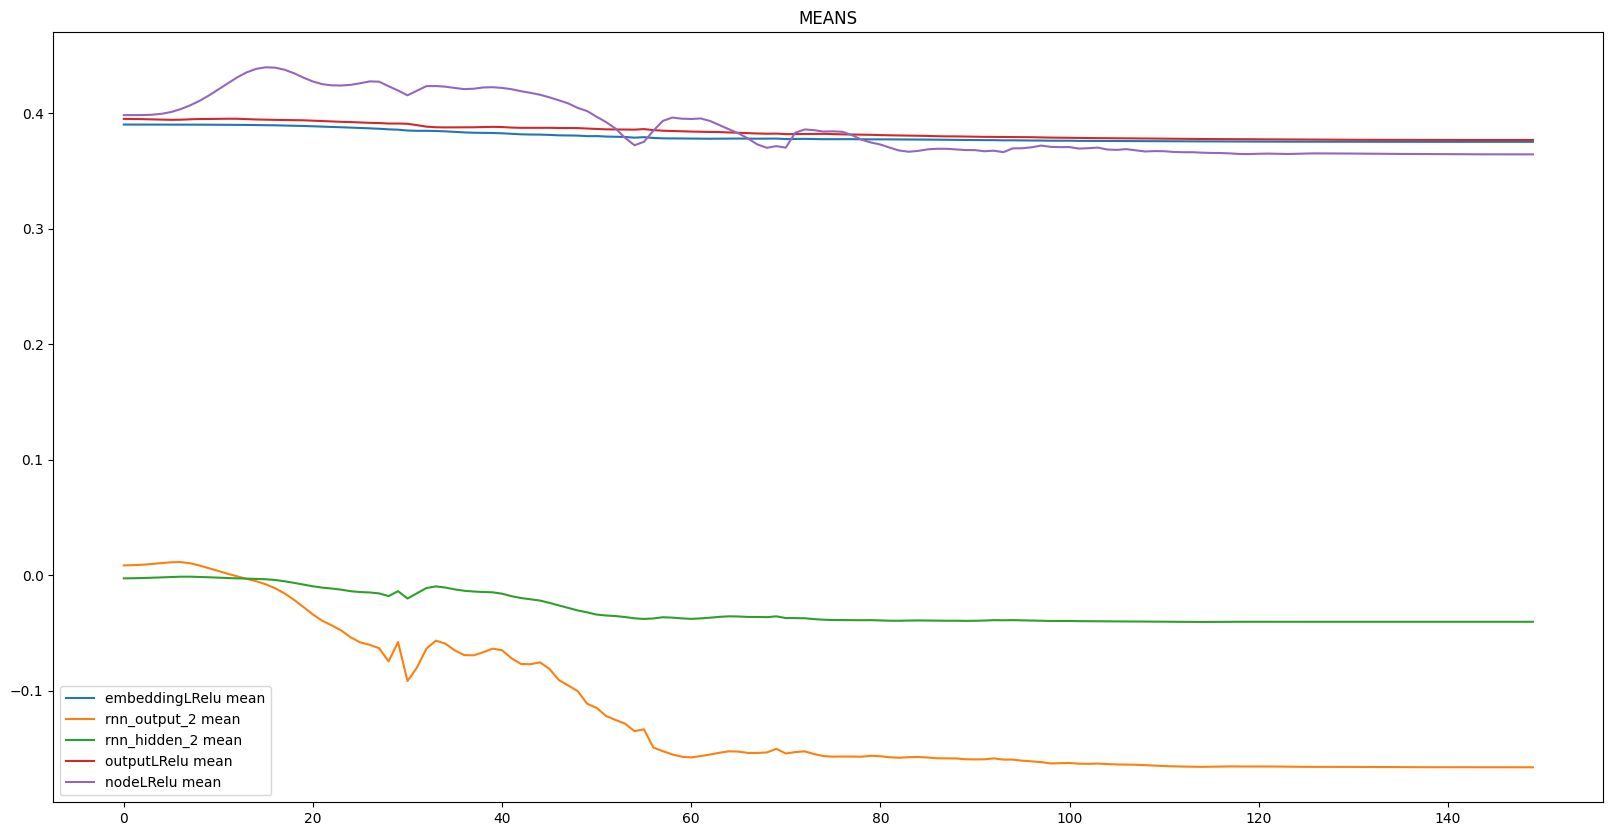

In [110]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_means_rnn.keys()):
    plt.plot([i for i in range(len(layer_means_rnn[k]))], layer_means_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')
plt.title("MEANS")

Text(0.5, 1.0, 'STDS')

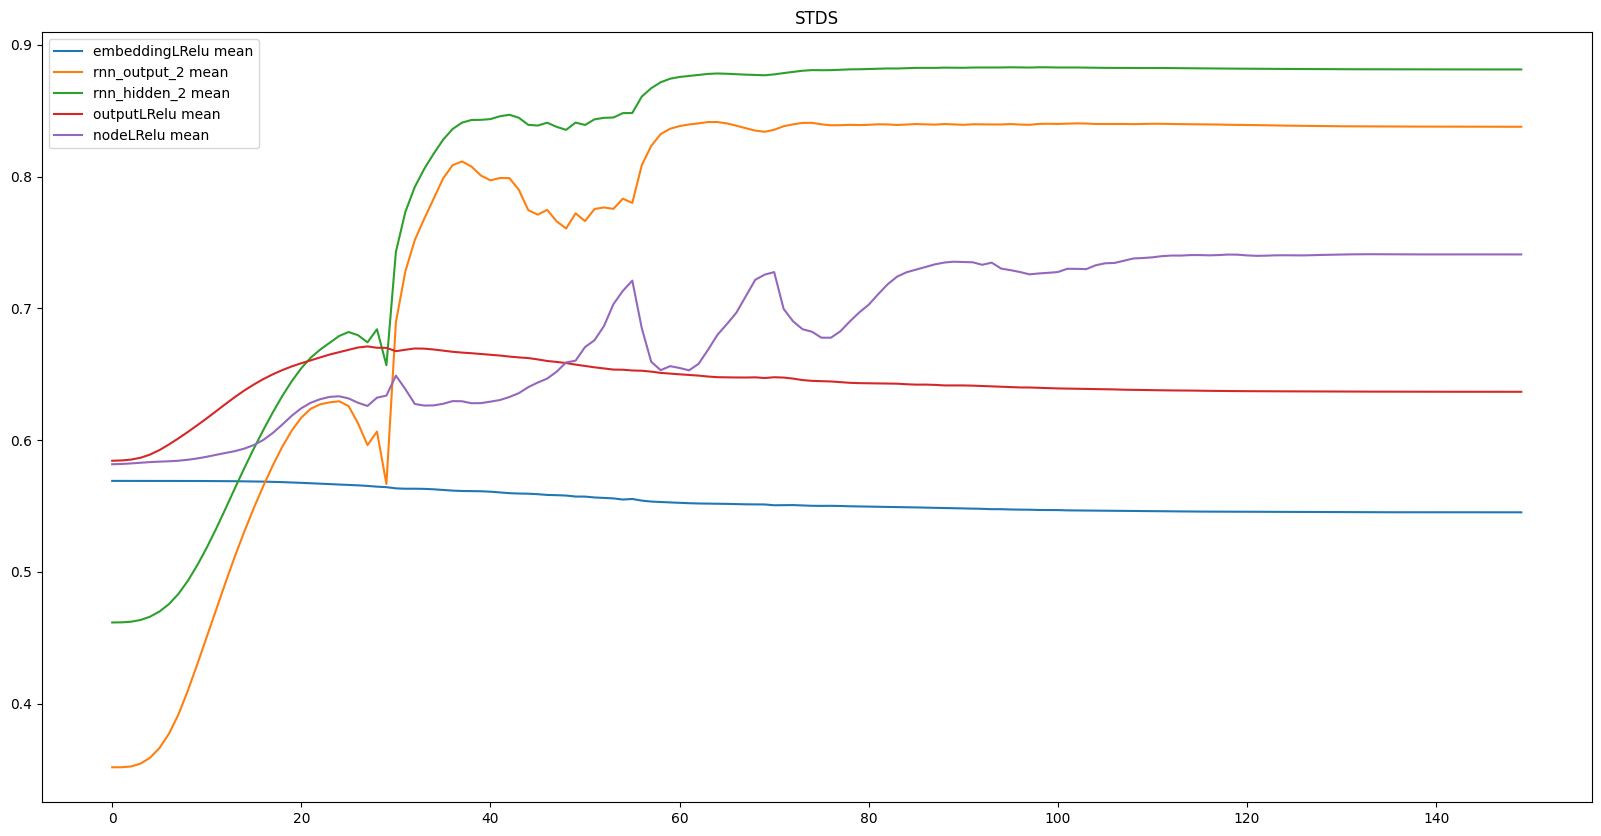

In [111]:
plt.figure(figsize=(20,10))
for color, k in enumerate(layer_hists_rnn.keys()):
    plt.plot([i for i in range(len(layer_stds_rnn[k]))], layer_stds_rnn[k], label=f'{k} mean'.format(i=color))
plt.legend(loc='best')
plt.title("STDS")

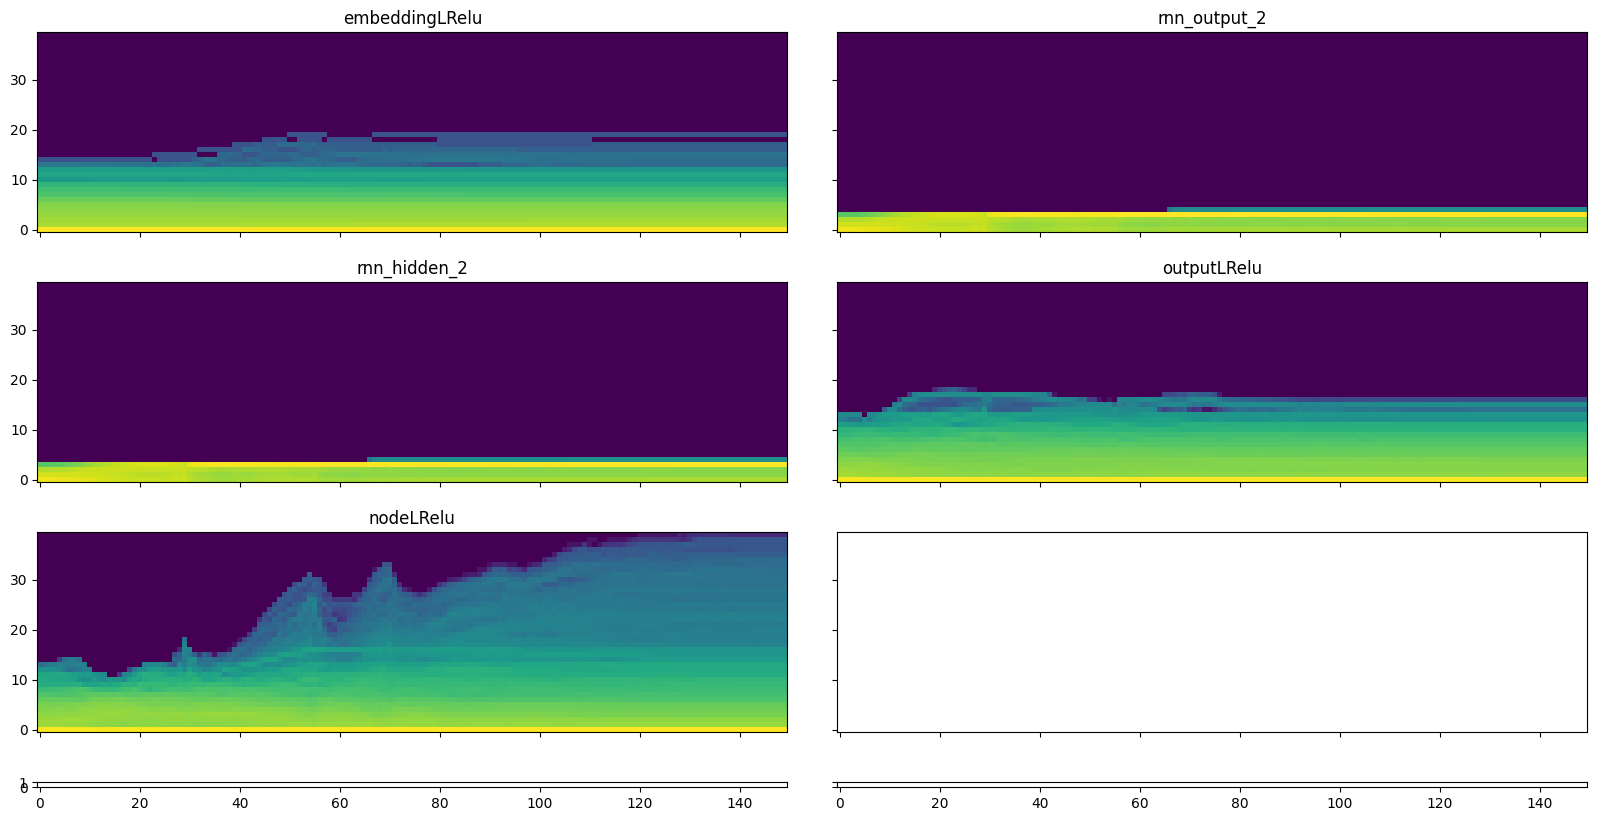

In [112]:
from mpl_toolkits.axes_grid1 import ImageGrid

def get_hist(h): return torch.stack(h).t().float().log1p() # with log you can see the range more clearly

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                )

for ax, k in zip(grid, list(layer_hists_rnn.keys())):
    # Iterating over the grid returns the Axes.
    im = get_hist(layer_hists_rnn[k])
    ax.imshow(im,  origin="lower",)
    ax.set_title(k)

plt.show()

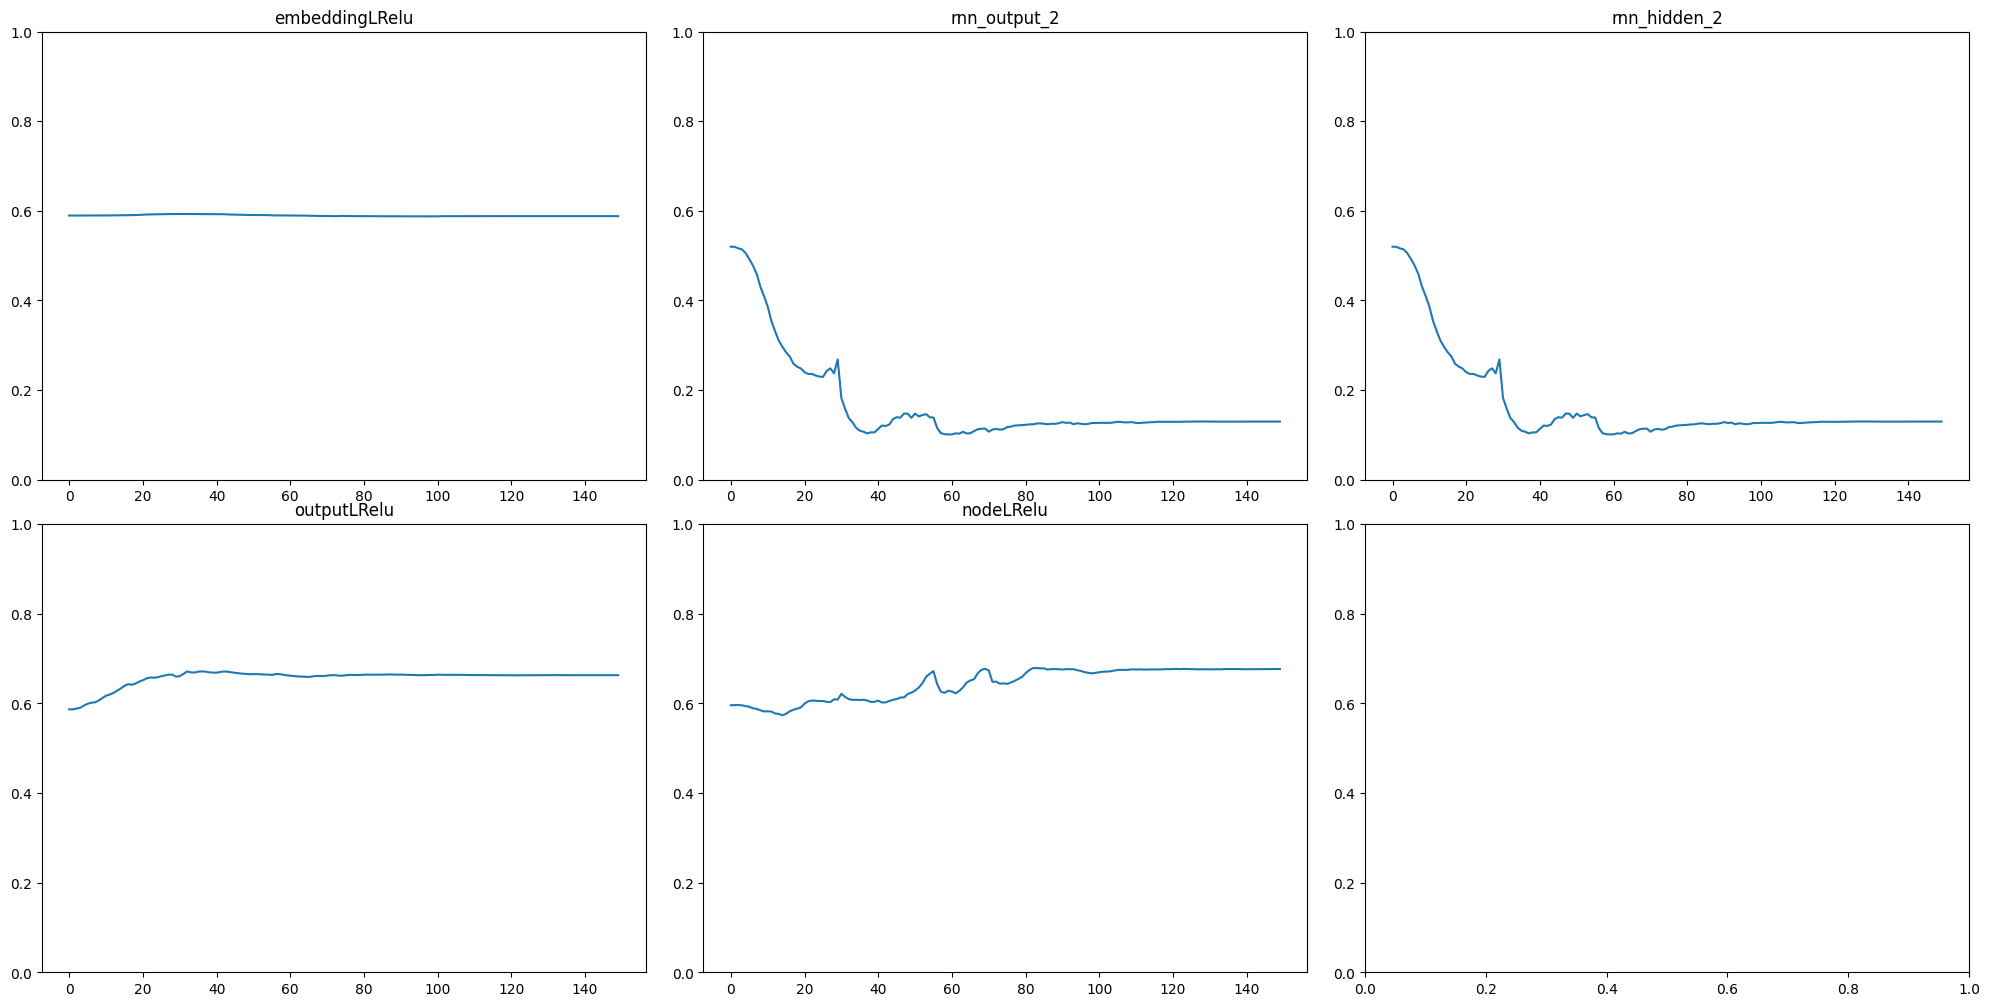

In [113]:
def get_min(h):
    h1 = torch.stack(h).t().float()
    return h1[0]/h1.sum(0)

fig, axes = plt.subplots(2,3, figsize=(20, 10))
fig.tight_layout()
for ax, k in zip(axes.flatten(), list(layer_hists_rnn.keys())):
    h = layer_hists_rnn[k]
    ax.plot(get_min(h))
    ax.set_title(k)
    ax.set_ylim(0,1)

# GRADIENTS

In [114]:
#! --- SET UP EXPERIMENT ---
epoch, max_epoch = 1, 150
train_data = get_random_batch(bs=bs)
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS
rnn, output = get_generator()

for m in [rnn, output]:
    m.apply(weight_init)
    m.ad_hoc_init()

optimizer = torch.optim.RMSprop(list(rnn.parameters()) + list(output.parameters()), lr=LR, weight_decay=wd, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_dataset_loader), epochs=max_epoch)

In [115]:
grads_dict = {}
for name, module in rnn.named_modules():
    for pname, p in module.named_parameters():
        if ".weight" in pname:
            grads_dict[pname] = []

@torch.no_grad()
def get_grads():
    for name, module in rnn.named_modules():
        for pname, p in module.named_parameters():
            if ".weight" in pname:
                grads_dict[pname].append(p.grad.data)

In [116]:
epoch = 0
update = []
while epoch < max_epoch:
    rnn.train()
    output.train()
    loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
    for batch_idx, data in enumerate(train_dataset_loader):
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        get_grads()
        if scheduler != None: 
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr'][0]
        
        with torch.no_grad():
            update.append([(current_lr* p.grad.std()/p.data.std()).log10().item() for p in rnn.parameters()])
        
        # nn.utils.clip_grad_value_(list(rnn.parameters()) + list(output.parameters()), clip_value=.25) # try .5,  0.25)

        optimizer.step()        
        if scheduler != None: scheduler.step()
        loss_sum_edges += edge_loss.item()
        loss_sum_nodes += node_loss.item()
        loss_all =  loss_sum_edges + loss_sum_nodes
        print(f"Epoch {epoch}, ", loss_all / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
    epoch +=1


Epoch 0,  0.9467547833919525 lossedges 0.5308905839920044  lossnodes  0.4158641993999481
Epoch 1,  0.933931827545166 lossedges 0.5199968218803406  lossnodes  0.41393500566482544
Epoch 2,  0.9125514924526215 lossedges 0.5019004940986633  lossnodes  0.41065099835395813
Epoch 3,  0.8854872584342957 lossedges 0.4794154763221741  lossnodes  0.4060717821121216
Epoch 4,  0.8535597026348114 lossedges 0.45348256826400757  lossnodes  0.40007713437080383
Epoch 5,  0.8145372271537781 lossedges 0.4220285415649414  lossnodes  0.39250868558883667
Epoch 6,  0.7653566300868988 lossedges 0.3821179270744324  lossnodes  0.38323870301246643
Epoch 7,  0.7050181031227112 lossedges 0.332762211561203  lossnodes  0.3722558915615082
Epoch 8,  0.6357159316539764 lossedges 0.2757638096809387  lossnodes  0.3599521219730377
Epoch 9,  0.562028169631958 lossedges 0.21481794118881226  lossnodes  0.34721022844314575
Epoch 10,  0.4907175600528717 lossedges 0.1551724672317505  lossnodes  0.3355450928211212
Epoch 11,  0.42

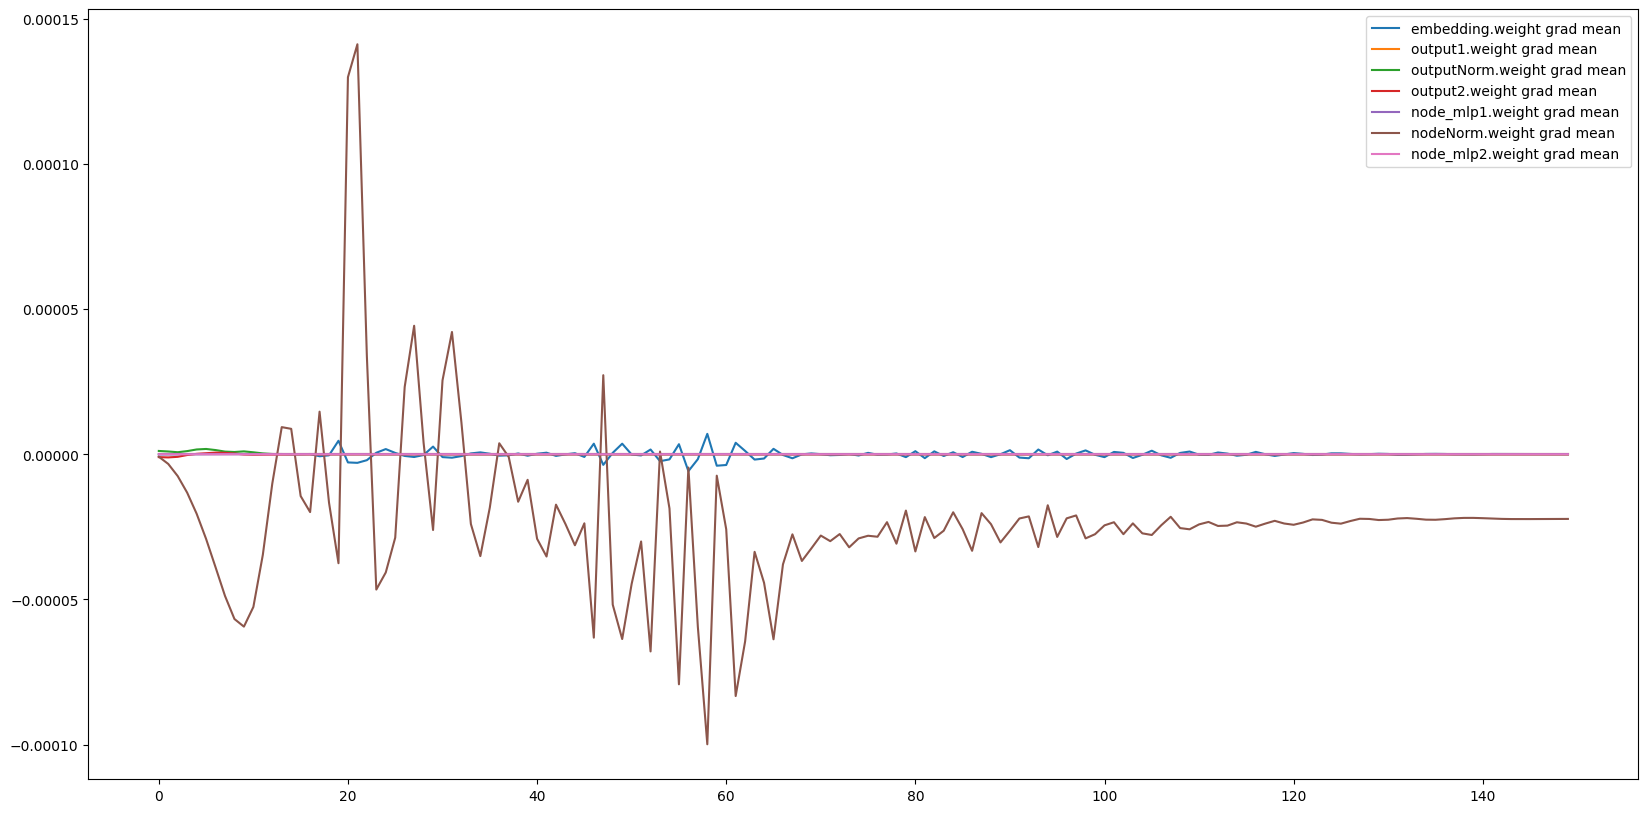

In [117]:
plt.figure(figsize=(20,10))
for color, k in enumerate(grads_dict.keys()):
    if "weight_" in k: continue
    l = grads_dict[k]
    r = range(len(l))
    plt.plot([i for i in r], [l[step].data.mean().cpu() for step in r], label=f'{k} grad mean'.format(i=color))
plt.legend(loc='best')

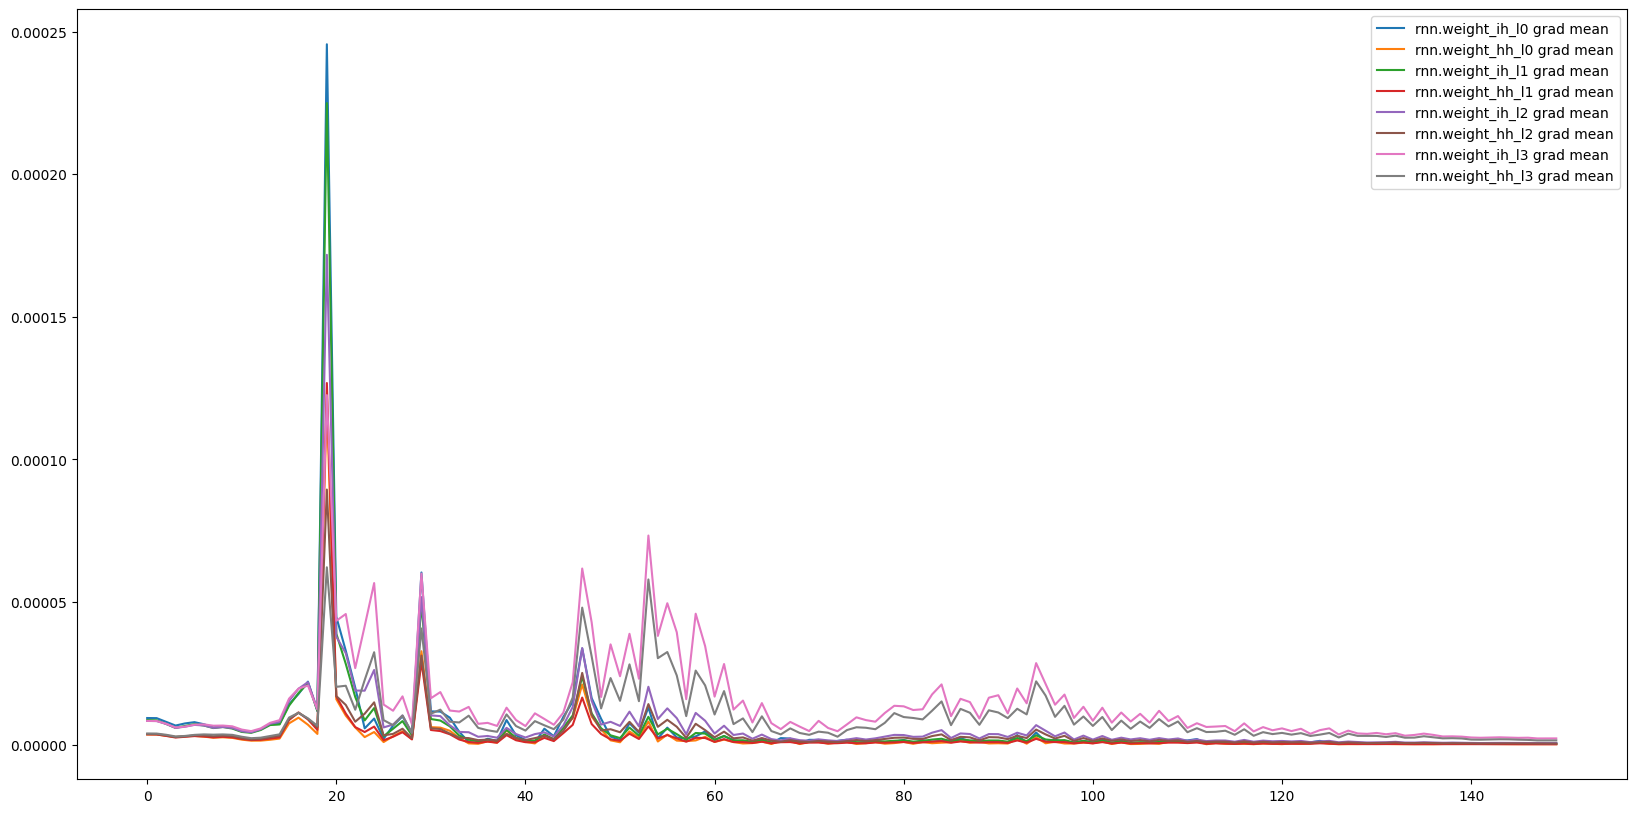

In [118]:
plt.figure(figsize=(20,10))
for color, k in enumerate(grads_dict.keys()):
    if "weight_" in k:
        l = grads_dict[k]
        r = range(len(l))
        plt.plot([i for i in r], [l[step].data.std().cpu() for step in r], label=f'{k} grad mean'.format(k=color))
plt.legend(loc='best')

Text(0.5, 1.0, 'weights and Gradients distribution')

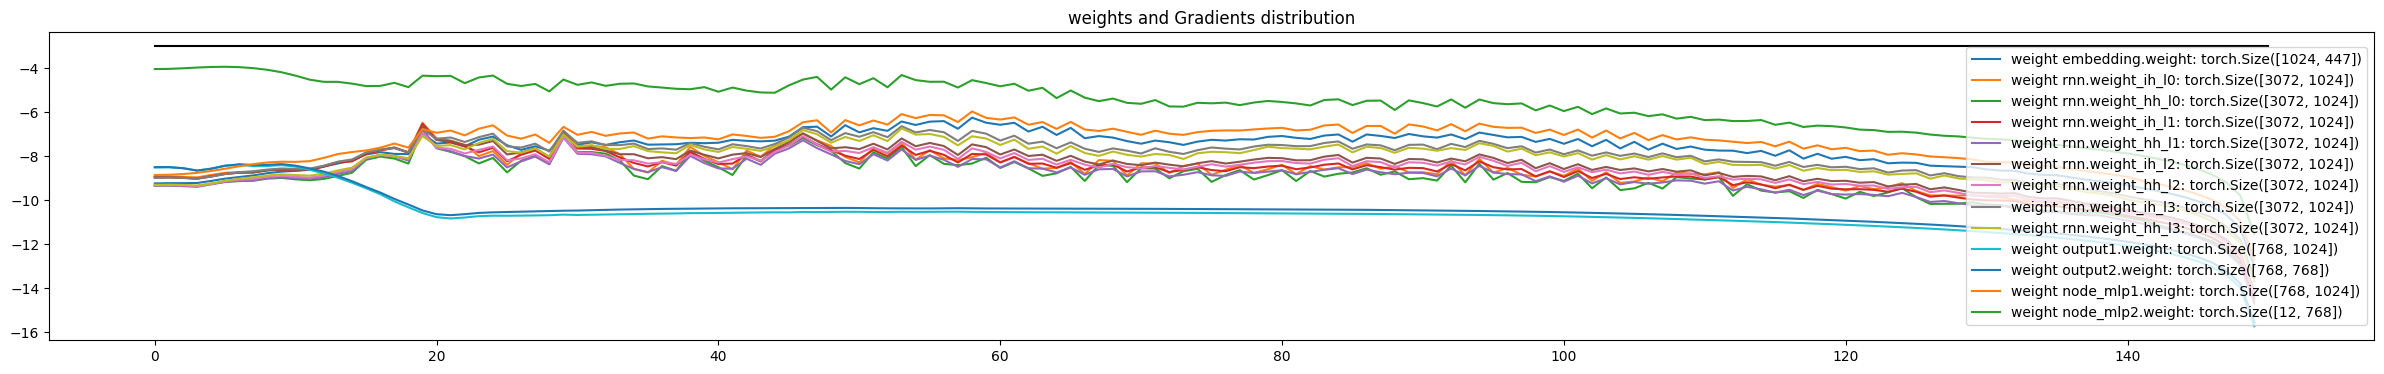

In [119]:
plt.figure(figsize=(30, 4))
legends = []
for i, (name, p) in enumerate(rnn.named_parameters()):
    if p.ndim == 2:
        plt.plot([update[j][i] for j in range(len(update))])
        legends.append(f'weight {name}: {p.shape}')
plt.plot([0, len(update)], [-3, -3], 'k') # guide/target ~ 1e-3
plt.legend(legends)
plt.title('weights and Gradients distribution')

In [120]:
# so theoretically we are not updating fast enough

# FASTAI lr finder

In [121]:
shuffle(train_guac_mols)
train_data = rdkit2pyg(train_guac_mols[:32])
train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS

rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=1e-6, weight_decay=10e-6, eps=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.3)

In [122]:
lrs, losses_lr = [], []
min_loss = math.inf
epoch = 0

while True:
    rnn.train()
    output.train()
    loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
    for batch_idx, data in enumerate(train_dataset_loader):
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        losses_lr.append(loss.item())
        if scheduler != None: current_lr = scheduler.get_last_lr()[0]
        else: current_lr = optimizer.param_groups[0]['lr']
        # nn.utils.clip_grad_value_(list(rnn.parameters()) + list(output.parameters()), clip_value=.25)
        optimizer.step()    
        lrs.append(current_lr)    
        if loss < min_loss: min_loss = loss
        if loss > 3 * min_loss: assert False
        if scheduler != None: scheduler.step()
        loss_sum_edges += edge_loss.data
        loss_sum_nodes += node_loss.data
        loss_all =  loss_sum_edges + loss_sum_nodes
        print(f"Epoch {epoch}, ", loss_all / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
    epoch +=1


Epoch 0,  tensor(1.0405, device='cuda:0') lossedges tensor(0.6040, device='cuda:0')  lossnodes  tensor(0.4365, device='cuda:0')
Epoch 1,  tensor(1.0370, device='cuda:0') lossedges tensor(0.6009, device='cuda:0')  lossnodes  tensor(0.4361, device='cuda:0')
Epoch 2,  tensor(1.0336, device='cuda:0') lossedges tensor(0.5980, device='cuda:0')  lossnodes  tensor(0.4356, device='cuda:0')
Epoch 3,  tensor(1.0299, device='cuda:0') lossedges tensor(0.5947, device='cuda:0')  lossnodes  tensor(0.4351, device='cuda:0')
Epoch 4,  tensor(1.0256, device='cuda:0') lossedges tensor(0.5910, device='cuda:0')  lossnodes  tensor(0.4346, device='cuda:0')
Epoch 5,  tensor(1.0205, device='cuda:0') lossedges tensor(0.5866, device='cuda:0')  lossnodes  tensor(0.4339, device='cuda:0')
Epoch 6,  tensor(1.0144, device='cuda:0') lossedges tensor(0.5812, device='cuda:0')  lossnodes  tensor(0.4332, device='cuda:0')
Epoch 7,  tensor(1.0070, device='cuda:0') lossedges tensor(0.5748, device='cuda:0')  lossnodes  tensor(0

AssertionError: 

Text(0, 0.5, 'Loss')

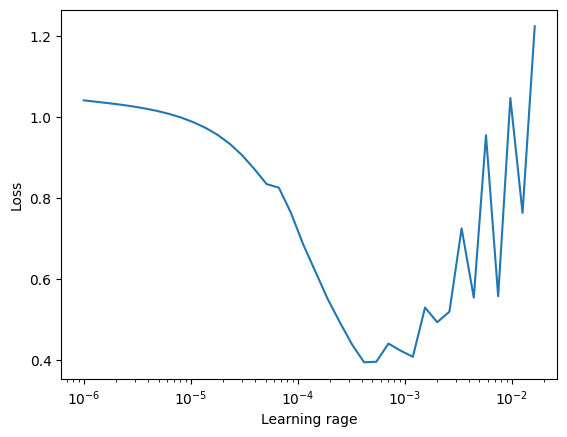

In [123]:
plt.plot(lrs, losses_lr)
plt.xscale('log')
plt.xlabel("Learning rage")
plt.ylabel("Loss")

In [ ]:
10**-4

# KARAPTHY lr finder TODO

In [ ]:
assert False

In [ ]:
max_linsp = 1000
lre = torch.linspace(-3, 0, max_linsp) # get linspace of exponents of 10**linspaced vals from [10e-3; 10e-0] = [0.001 to 1] 
lrs = 10**lre # actual lrs to be tested
# plt.plot(lrs) # we want to search between these 1000 lrs

In [ ]:
shuffle(train_guac_mols)
train_data = rdkit2pyg(train_guac_mols[:32])

train_dataset_loader, val_dataset_loader = create_train_val_dataloaders(train_data, train_data, max_num_node, max_prev_node, bs) #! HERE WORKERS

rnn, output = get_generator()
rnn.apply(weight_init)
output.apply(weight_init)
rnn.ad_hoc_init()
output.ad_hoc_init()

params = list(rnn.parameters()) + list(output.parameters())
optimizer = torch.optim.RMSprop(params, lr=1e-6, weight_decay=5e-4, eps=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.3)

In [ ]:
def update_params(params, lr):
    '''
    params: iterable containing params tensors
    lr: learning rate
    '''    
    for p in params:
        p.data += - lr * p.grad

In [ ]:
rnn.train()
output.train()
lri, lossi = [], []
for batch_idx, data in enumerate(train_dataset_loader):
    for i in range(max_linsp):
        loss_all, loss_sum_edges, loss_sum_nodes = 0, 0, 0
        rnn.zero_grad()
        output.zero_grad()
        loss, edge_loss, node_loss = fit_batch(data, rnn, output, node_weights, edge_weights)
        loss.backward()
        lossi.append(loss.item())
        if scheduler != None: current_lr = scheduler.get_last_lr()[0]
        else: current_lr = optimizer.param_groups[0]['lr'][0]

        # optimizer.step()    
        update_params(rnn.parameters(), lrs[i])    
        update_params(output.parameters(), lrs[i])    
        lri.append(lrs[i])    
        
        # if scheduler != None: scheduler.step()
        
        loss_sum_edges += edge_loss.data
        loss_sum_nodes += node_loss.data
        loss_all =  loss_sum_edges + loss_sum_nodes
        print(f"Epoch {epoch}, ", loss / (batch_idx + 1), 'lossedges', loss_sum_edges / (batch_idx + 1), ' lossnodes ',loss_sum_nodes / (batch_idx + 1))
    assert False


In [ ]:
plt.plot(lri, lossi) # 10 ** -1 is good, use the one u got when overfitting a single batch


In [ ]:
index_min = np.argmin(lossi[:200])
lri[index_min]